# Parameters Visualization titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv("titanic-clean.csv")

# Categorical Features

In [3]:
select_features = ["Survived", "Pclass", "Sex", "Age", "SibSp"]
categorical_features = ["Pclass", "Sex"]

In [4]:
df = df[select_features]
df.head()

,Survived,Pclass,Sex,Age,SibSp
0,0,3,male,22.0,1
1,1,1,female,38.0,1
2,1,3,female,26.0,0
3,1,1,female,35.0,1
4,0,3,male,35.0,0


# One-Hot-Encoder

In [5]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoder.fit(df[categorical_features])
one_hot_encoder

OneHotEncoder(handle_unknown='ignore')

In [6]:
# retrieving the column names from the OneHotEncoder

column_names = one_hot_encoder.get_feature_names_out(categorical_features)
column_names

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male'],
      dtype=object)

In [7]:
# applying the one-hot-encoder on the categorical columns

transformed_data = one_hot_encoder.transform(df[categorical_features])
transformed_data

<889x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1778 stored elements in Compressed Sparse Row format>

In [8]:
# Converting the sparse matrix to dataframe

df_transformed = pd.DataFrame.sparse.from_spmatrix(transformed_data,
                                                   columns=column_names)
df_transformed

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0,1.0,0,1.0
1,1.0,0,0,1.0,0
2,0,0,1.0,1.0,0
3,1.0,0,0,1.0,0
4,0,0,1.0,0,1.0
...,...,...,...,...,...
884,0,1.0,0,0,1.0
885,1.0,0,0,1.0,0
886,0,0,1.0,1.0,0
887,1.0,0,0,0,1.0


In [9]:
# extracting only the columns that didnt need to be encoded

df = df.drop(columns=categorical_features)
df.head()

,Survived,Age,SibSp
0,0,22.0,1
1,1,38.0,1
2,1,26.0,0
3,1,35.0,1
4,0,35.0,0


In [10]:
# merging/joing the transformed data frame with categorical data with a datafram containing non-categorical features

final_df = df.join(df_transformed)
final_df.head()

,Survived,Age,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,1,0,0,1.0,0,1.0
1,1,38.0,1,1.0,0,0,1.0,0
2,1,26.0,0,0,0,1.0,1.0,0
3,1,35.0,1,1.0,0,0,1.0,0
4,0,35.0,0,0,0,1.0,0,1.0


In [11]:
final_df.dtypes

Survived                   int64
Age                      float64
SibSp                      int64
Pclass_1      Sparse[float64, 0]
Pclass_2      Sparse[float64, 0]
Pclass_3      Sparse[float64, 0]
Sex_female    Sparse[float64, 0]
Sex_male      Sparse[float64, 0]
dtype: object

# Converting Sparse into Int

In [12]:
final_df[column_names] = final_df[column_names].sparse.to_dense()
conversion = {}
for col in column_names:
    conversion[col] = 'int8'

final_df = final_df.astype(conversion)
final_df.dtypes

Survived        int64
Age           float64
SibSp           int64
Pclass_1         int8
Pclass_2         int8
Pclass_3         int8
Sex_female       int8
Sex_male         int8
dtype: object

# Scaling

In [13]:
final_df.head()

,Survived,Age,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,1,0,0,1,0,1
1,1,38.0,1,1,0,0,1,0
2,1,26.0,0,0,0,1,1,0
3,1,35.0,1,1,0,0,1,0
4,0,35.0,0,0,0,1,0,1


In [14]:
df_list = []
scaler_names = ["MinMax", "Standard", "Robust"]

In [15]:
features_to_scale = ["Age", "SibSp"]


In [16]:
scaler=MinMaxScaler(clip=True)
df_temp=final_df.copy()
df_temp[features_to_scale]=scaler.fit_transform(final_df[features_to_scale])
df_list.append(df_temp)

scaler=RobustScaler()
df_temp=final_df.copy()
df_temp[features_to_scale]=scaler.fit_transform(final_df[features_to_scale])
df_list.append(df_temp)

scaler=StandardScaler()
df_temp=final_df.copy()
df_temp[features_to_scale]=scaler.fit_transform(final_df[features_to_scale])
df_list.append(df_temp)

len(df_list)

3

In [17]:
df_list[0].head()

,Survived,Age,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0.271174,0.125,0,0,1,0,1
1,1,0.472229,0.125,1,0,0,1,0
2,1,0.321438,0.000,0,0,1,1,0
3,1,0.434531,0.125,1,0,0,1,0
4,0,0.434531,0.000,0,0,1,0,1


# Spliting & Modeling

In [18]:
loss_curves={}
val_curves={}
test_scores={}
train_scores={}

solvers=['adam','sgd']
hidden_layers = [(100, 80, 50,), (200, 200, 200,), (30, 30,), (50, 25,), (1000,), (80, 100, 80,)]

for index,df in enumerate(df_list):
    X=df.drop(columns=["Survived"])
    y=df[["Survived"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)



    for solver in solvers:
        for hl in hidden_layers:

            model=MLPClassifier(random_state=42,
                                max_iter=1000,
                                solver=solver,
                                hidden_layer_sizes=hl,
                                n_iter_no_change=60,
                                early_stopping=True,
                                validation_fraction=0.1,
                                verbose=False)
            model.fit(X_train, y_train.astype("int"))
            loss_curves[f"{scaler_names[index]}-{solver}-{hl}"]=model.loss_curve_
            val_curves[f"{scaler_names[index]}-{solver}-{hl}"]=model.validation_scores_
            test_scores[f"{scaler_names[index]}-{solver}-{hl}"]=model.score(X_test,y_test)
            train_scores[f"{scaler_names[index]}-{solver}-{hl}"]=model.score(X_train,y_train)

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lenovo\AppData\Local\Programs\Python\

# Visualization

 To get the output please install this `https://plotly.com/python/getting-started/`

In [19]:
import plotly.express as px

fig = px.line(x=list(test_scores.keys()), y=list(test_scores.values()), color=px.Constant("Test"),
             labels=dict(x="Features", y="Accuracy", color="Type"))
fig.add_bar(x=list(train_scores.keys()), y=list(train_scores.values()), name="Train")
fig.show()

In [20]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(test_scores.keys()), y=list(test_scores.values())))
fig.show()

In [21]:
fig = go.Figure()
for key in loss_curves.keys():
    fig.add_trace(go.Line(x=list(range(len(loss_curves[key]))),
                           y=loss_curves[key],
                           name=key))
fig.update_layout({"height": 700})
fig.show()

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




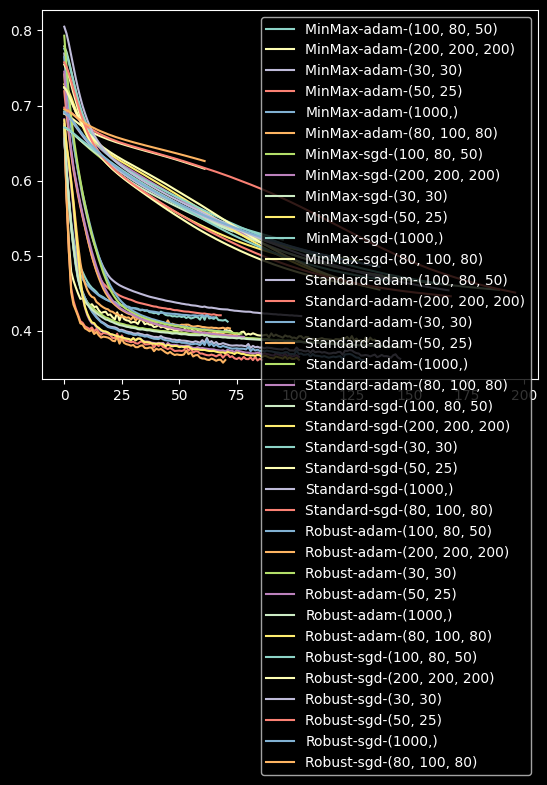

In [22]:
for key in loss_curves.keys():
    plt.plot(loss_curves[key],
             label=key)
plt.legend()
plt.show()

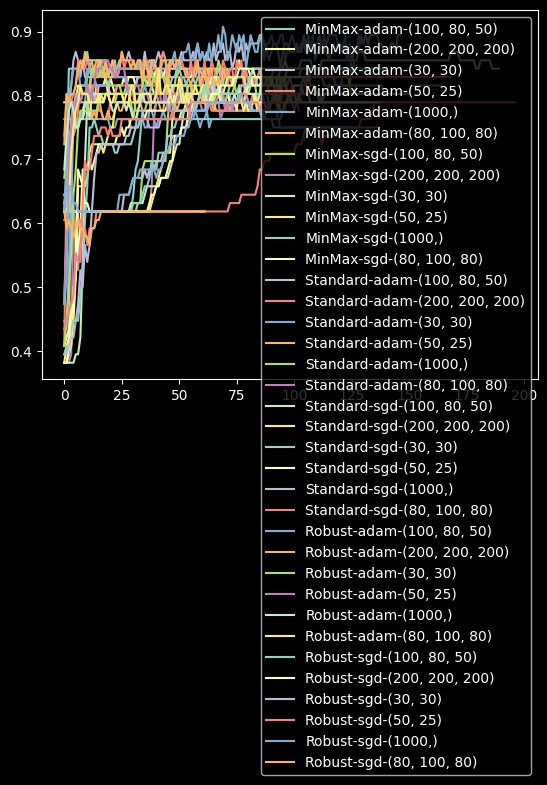

In [23]:
for key in val_curves.keys():
    plt.plot(val_curves[key],
             label=key)
plt.legend()
plt.show()